In [2]:
import pandas as pd
import numpy as np
import math
import gc
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib import rcParams 
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['pdf.fonttype'] = 42
sns.set_color_codes("muted")

In [3]:
rcParams['pdf.fonttype'] = 42 # True font
rcParams['font.family'] =  'Arial' # font Arial
rcParams['font.size'] =  8  
rcParams['grid.linewidth'] =  0.5 
rcParams['lines.color'] = 'b' 
rcParams['lines.linewidth'] = 1 
rcParams['lines.markersize'] = 3
rcParams['lines.markeredgewidth'] = 0 # set Marker with no edgelines
rcParams['axes.linewidth'] = 0.5

rcParams['axes.titlesize'] = 12
rcParams['axes.labelsize'] = 8
rcParams['xtick.labelsize'] = 6
rcParams['ytick.labelsize'] = 6
rcParams['legend.fontsize'] = 6
rcParams['legend.title_fontsize'] = 8

In [4]:
# Loading
def LoadMatrixReader(filename, Chunksize, colnamelist, usecols,  sepstr="\t"):
    file_reader = pd.read_table(filename, sep=sepstr,
                                chunksize=Chunksize, iterator=True,
                                header=None, index_col=None, names = colnamelist, usecols = usecols)

    return (file_reader)

# read fragment count
def FragmentCount(df):
    Fragmentcount = df.groupby(by="read_name", as_index=True)["chr1"].count()
    df.loc[:, "Fragnum"] = 0
    df.loc[:, "Fragnum"] = df["read_name"].apply(lambda x : Fragmentcount.loc[x] )
    return(df)

# chrom filter
def ChromFilter(df, chromlist):
    P = ( df.chr1.isin(chromlist) ) |  (df.chr2.isin(chromlist) )
    df = df.loc[~ P, :]
    return(df)

# Filter Inter chromosome contact
def InterFilter(df):
    df = df.loc[df.chr1 != df.chr2, :]
    return(df)

# binID
def binIDtag(chromarray, posarray, binsize=1000000):
    posarray = [int(math.floor(i/binsize) ) for i in posarray ]
    taglist = ["%s_%d"%(chrom, i) for chrom, i in zip(chromarray, posarray)  ]
    return(taglist)

# Deduplicate Intercontact
def DeduplicateContact(df):
    '''
    deduplicate read's bintag contact pairs 
    '''
    de_df = df.loc[:,["read_name", "bin1tag", "bin2tag"]].drop_duplicates(subset=["read_name", "bin1tag", "bin2tag"],
                                                                          keep='first')
    return(de_df)

# Count Intercontacts
def CountInterContact(df):
    '''
    Count frequence of each bin pairs 
    '''
    freq_df = df.groupby(["bin1tag", "bin2tag"], as_index=False)["read_name"].count()
    freq_df.columns = ["bin1tag", "bin2tag", "Freq"]
    return(freq_df)

# Contact Merge
def MergeContact(freq_df):
    '''
    Sum the same bin pairs contact count
    '''
    sum_df = freq_df.groupby(["bin1tag", "bin2tag"])["Freq"].sum()
    sum_df = sum_df.reset_index()
    sum_df.columns = ["bin1tag", "bin2tag", "Freq"]
    return(sum_df)
    

In [5]:
# juice matrix file
juicefile = "/data1/ZJY/Pore-C/Analysis/NA12878/Merge_NA12878/juiceMatrix/juice_matrix_inter_chromosome.txt"
Chunksize = 100000
colnamelist = ["read_name", "str1", "chr1", "pos1","frag1","str2", "chr2", "pos2","frag2","mapq1", "mapq2"]
usecols = ["read_name", "chr1", "pos1", "chr2", "pos2"]
file_reader = LoadMatrixReader(juicefile, Chunksize, colnamelist, usecols,"\t")
dflist = []
for df in file_reader:
    #df = FragmentCount(df)
    df = InterFilter(df)
    df.loc[:, "bin1tag"] = binIDtag(df.chr1.to_list() , df.pos1.to_list(), binsize=1000000)
    df.loc[:, "bin2tag"] = binIDtag(df.chr2.to_list() , df.pos2.to_list(), binsize=1000000)
    de_df = DeduplicateContact(df) # deduplicate
    freq_df = CountInterContact(de_df) # freq count
    dflist.append(freq_df)
    del(df, de_df, freq_df)
    gc.collect()
# concat  result
BP_freq = pd.concat(dflist)
BP_freq  = MergeContact(BP_freq) # Merge the same pair contact

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


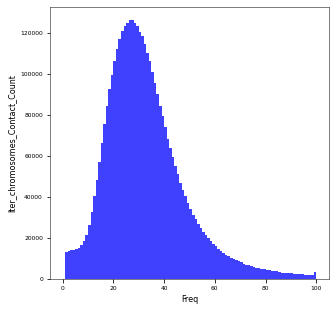

In [7]:
#Freq distribution
plt.figure(figsize=(5,5))
plt.hist(BP_freq.Freq,bins=100,range=[0,100], histtype='bar',facecolor='blue',alpha=0.75)
plt.ylabel("Iter_chromosomes_Contact_Count")
plt.xlabel("Freq")
#plt.yscale('log')
plt.show()

In [8]:
# chromosome length
## Chromosome bin
chromlen_file = "/data1/ZJY/Pore-C/HiGlass/data/hg38.chromosomesize.csv"
chromlen_df = pd.read_csv(chromlen_file, sep="\t", header=None, index_col=None, names=["chrom", "len"])
## Centermere
centermere_file = "/data1/ZJY/Pore-C/HiGlass/data/Annotation/UCSC_hg38_Centromere.txt"
cenmere_df = pd.read_csv(centermere_file, sep="\t", header=None, index_col=None, names=["chrom", "start", "end"])
## Telomere
telomere_len = 10000

In [9]:
# Chromosome bin
chromlen_dict = {"chrom":[], 
                 "start":[], 
                 "end":[],
                "binType":[]}
binsize = 1000000
## chromosome interval
for n, rowvalue in chromlen_df.iterrows():
    chrom = rowvalue["chrom"]
    itervals =  list( np.arange(0, rowvalue["len"], binsize) )
    if itervals[-1] < rowvalue["len"]:
        itervals.append(rowvalue["len"])
    # stars, ends
    stars = itervals[0:-1] 
    ends = itervals[1:-1] 
    ends.append(rowvalue["len"])
    chromlen_dict["chrom"].extend( len(stars) *  [chrom] )
    chromlen_dict["start"].extend( stars )
    chromlen_dict["end"].extend( ends )
    # Bintype 
    bintypelist = []
    ## chr centromere type
    ct_start, ct_end = cenmere_df.loc[cenmere_df.chrom==chrom]["start"].iloc[0],  cenmere_df.loc[cenmere_df.chrom==chrom, "end"].iloc[0]
    for si, ei in zip(stars, ends):
        if (si >= ct_start and si < ct_end) or (ei > ct_start and ei< ct_end ):
            bintypelist.append("cent")
        else:
            bintypelist.append("normal")
    ## Telomere type
    bintypelist[0] = "telo"
    bintypelist[-1] = "telo"
    chromlen_dict["binType"].extend( bintypelist )
## BinID
chrombin_df = pd.DataFrame(chromlen_dict)
## filter out chrX, chrY
chrombin_df = chrombin_df.loc[~ chrombin_df.chrom.isin(["chrY"]), :]
chrombin_df.loc[:, "binID"] = chrombin_df.index.values + 1
chrombin_df.loc[:, "bintag"] = ["%s_%d"%(chrom, i) for chrom, i in zip(chrombin_df.chrom.to_list(),  
                                                                  np.divide(chrombin_df.start.values, binsize).astype(int) ) ]
chrombin_df.loc[chrombin_df.chrom=="chr22", :].head(20)
chrombin_dict = dict( list( chrombin_df.groupby("chrom") ) )

## Inter chrom combination
'''
bintag combination , inter chromosomes
'''
bintaglist = chrombin_df.bintag.to_list()
import itertools
alist = [ "a", "b", "c", "d" ]
Tag_pairs= list( itertools.combinations(bintaglist,2) )

In [10]:
print( chrombin_df.shape )
chrombin_df.head(20)
# bintag index
BintagIndex = {}
for n, rowvalue in chrombin_df.iterrows():
    bintag = rowvalue["bintag"]
    BintagIndex[bintag] = n
print( bintag, BintagIndex[bintag] )
chrombin_df = chrombin_df.set_index("bintag", drop=False)
chrombin_df.tail(20)

(3044, 6)
chrX_156 3043


,chrom,start,end,binType,binID,bintag
bintag,,,,,,
chrX_137,chrX,137000000,138000000,normal,3025,chrX_137
chrX_138,chrX,138000000,139000000,normal,3026,chrX_138
chrX_139,chrX,139000000,140000000,normal,3027,chrX_139
chrX_140,chrX,140000000,141000000,normal,3028,chrX_140
chrX_141,chrX,141000000,142000000,normal,3029,chrX_141
chrX_142,chrX,142000000,143000000,normal,3030,chrX_142
chrX_143,chrX,143000000,144000000,normal,3031,chrX_143
chrX_144,chrX,144000000,145000000,normal,3032,chrX_144
chrX_145,chrX,145000000,146000000,normal,3033,chrX_145


In [11]:
import itertools
bintaglist = chrombin_df.bintag.to_list()
Tag_pairs= list( itertools.combinations(bintaglist,2) ) 
alist = [ item[0] for item in Tag_pairs  ]
blist = [ item[1] for item in Tag_pairs  ]
Com_df = pd.DataFrame({"Tag1":alist,
                      "Tag2":blist,
                      "chr1":[tag.split("_")[0] for tag in alist ],
                      "chr2":[tag.split("_")[0] for tag in blist ]})
## filter intra
InterCom_df = Com_df.loc[Com_df.chr1 != Com_df.chr2, :]

In [12]:
from scipy.special import comb, perm
import math 
# Binomial distribution calculate
def BinomialProb(M, n, k):
    '''
    M : the number of bin contact pair types
    n : total number of contact pairs
    k : obser of a specific contact pair
    P(x) = lumda^x * e^-lumda/ x!
    '''
    # Enrichment score = Obser/Expect
    #Ev = n/M    es = k /Ev = k*M/n
    es = k*M/n 
    # Probability and p_value
    p = float(1/M) # probability of each pair
    lumda = int(n*p)
    try:
        Pr = pow(lumda, k)*math.exp( -1*lumda) * pow( math.factorial(k), -1)
    except:
        Pr = 0.0
    if Pr <= 0.0:
        Pr = 0.0 # 数值溢出，负数
    p_value = 0.0
    for ki in range(k, k+100):
        try:
            Pi = pow(lumda, ki)*math.exp( -1*lumda)*pow( math.factorial(ki), -1)
        except:
            Pi = 0.0
        p_value += Pi
    ## save result
    BP_dict["k"].append(k)        
    BP_dict["Prob"].append(Pr)
    BP_dict["EnrichS"].append(es)
    BP_dict["p_value"].append(p_value)

In [13]:
# Calclulate Probability and Enrichment scores
BP_dict = {"k":[],
           "Prob":[],
           "EnrichS":[],
           "p_value":[]}

NumTypes = len(BP_freq)
totalN = BP_freq.Freq.sum()

for kn in list(set( list(BP_freq["Freq"].values) ) ) :
    BinomialProb(NumTypes, totalN, kn)
    
BP_df = pd.DataFrame(BP_dict)
BP_df = BP_df.set_index("k")
BP_df.head(100)

,Prob,EnrichS,p_value
k,,,
1,5.827289e-14,0.029105,1.000000e+00
2,9.906391e-13,0.058210,1.000000e+00
3,1.122724e-11,0.087315,1.000000e+00
4,9.543156e-11,0.116420,1.000000e+00
5,6.489346e-10,0.145525,1.000000e+00
...,...,...,...
96,0.000000e+00,2.794085,2.791061e-18
97,0.000000e+00,2.823190,9.730645e-19
98,0.000000e+00,2.852295,3.358287e-19


In [14]:
### Probability
BP_freq.loc[:,"Prob"] = BP_freq["Freq"].apply(lambda x: BP_df.loc[x, "Prob"] )
BP_freq.loc[:,"EnrichS"] = BP_freq["Freq"].apply(lambda x: BP_df.loc[x, "EnrichS"] )
BP_freq.loc[:,"p_value"] = BP_freq["Freq"].apply(lambda x: BP_df.loc[x, "p_value"] )
### Multitest p adjust
from statsmodels.stats.multitest import multipletests
raw_pvals = BP_freq.p_value.values
alpha = 0.01 # FDR 0.01
rejected, p_adjusted, _, alpha_corrected = multipletests(raw_pvals, alpha=alpha, 
                               method='bonferroni', is_sorted=False, returnsorted=False)
#print( np.sum(rejected), alpha_corrected   )
BP_freq.loc[:, "p_adjusted"] = p_adjusted
BP_freq

,bin1tag,bin2tag,Freq,Prob,EnrichS,p_value,p_adjusted
0,chr10_0,chr11_0,132,0.000000e+00,3.841867,2.941068e-37,1.196942e-30
1,chr10_0,chr11_1,65,0.000000e+00,1.891828,1.484266e-06,1.000000e+00
2,chr10_0,chr11_10,56,0.000000e+00,1.629883,3.350620e-04,1.000000e+00
3,chr10_0,chr11_100,40,0.000000e+00,1.164202,1.717350e-01,1.000000e+00
4,chr10_0,chr11_101,33,7.634368e-35,0.960467,5.910600e-01,1.000000e+00
...,...,...,...,...,...,...,...
4069749,chr9_99,chrX_95,20,4.144332e-15,0.582101,9.962510e-01,1.000000e+00
4069750,chr9_99,chrX_96,23,0.000000e+00,0.669416,9.808760e-01,1.000000e+00
4069751,chr9_99,chrX_97,20,4.144332e-15,0.582101,9.962510e-01,1.000000e+00
4069752,chr9_99,chrX_98,13,2.023359e-06,0.378366,9.999871e-01,1.000000e+00


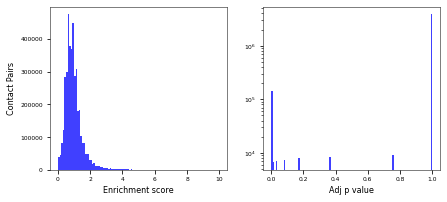

In [15]:
# Enrichment score distribution
plt.figure(figsize=(7,3))
ax1 = plt.subplot(1,2,1)
plt.hist(BP_freq.EnrichS.values,bins=100,range=[0,10], histtype='bar',facecolor='blue',alpha=0.75)
plt.ylabel("Contact Pairs")
plt.xlabel("Enrichment score")
#plt.yscale('log')
#plt.show()
# Enrichment score distribution
#plt.figure(figsize=(5,5))
ax2 = plt.subplot(1,2,2)
plt.hist(BP_freq.p_adjusted.values,bins=100,range=[0,1], histtype='bar',facecolor='blue',alpha=0.75)
#plt.ylabel("Contact ")
plt.xlabel("Adj p value")
plt.yscale('log')
#plt.show()
plt.savefig("Enrichment_score_distribution.pdf")

In [16]:
BP_freq

,bin1tag,bin2tag,Freq,Prob,EnrichS,p_value,p_adjusted
0,chr10_0,chr11_0,132,0.000000e+00,3.841867,2.941068e-37,1.196942e-30
1,chr10_0,chr11_1,65,0.000000e+00,1.891828,1.484266e-06,1.000000e+00
2,chr10_0,chr11_10,56,0.000000e+00,1.629883,3.350620e-04,1.000000e+00
3,chr10_0,chr11_100,40,0.000000e+00,1.164202,1.717350e-01,1.000000e+00
4,chr10_0,chr11_101,33,7.634368e-35,0.960467,5.910600e-01,1.000000e+00
...,...,...,...,...,...,...,...
4069749,chr9_99,chrX_95,20,4.144332e-15,0.582101,9.962510e-01,1.000000e+00
4069750,chr9_99,chrX_96,23,0.000000e+00,0.669416,9.808760e-01,1.000000e+00
4069751,chr9_99,chrX_97,20,4.144332e-15,0.582101,9.962510e-01,1.000000e+00
4069752,chr9_99,chrX_98,13,2.023359e-06,0.378366,9.999871e-01,1.000000e+00


In [17]:
# Definde Importand Inter chromosomae Interaction
'''
Filter
1. Significant Enrichment Contacts
2. Consecutive contacts i±1， j±1 are significant
2.1  telomere consecutive
'''
Esthred, p_thred = 2, 0.01
eP = (BP_freq.EnrichS >= Esthred) & (BP_freq.p_adjusted < p_thred )
BP_freq_Filter = BP_freq.loc[eP, :]
BP_freq_Filter = BP_freq_Filter.reset_index(drop=True)
print(len(BP_freq_Filter))
#BP_freq_Filter 
## 2 Consecutive filter
TagPairs = ["%s-%s"%(itag, jtag) for itag, jtag in zip(BP_freq_Filter.bin1tag.to_list(), BP_freq_Filter.bin2tag.to_list() )  ]
Consectu_P = []
for n, rowvalue in BP_freq_Filter.iterrows():
    bin1tag, bin2tag = rowvalue["bin1tag"], rowvalue["bin2tag"]
    chrom1, chrom2 = bin1tag.split("_")[0] ,  bin2tag.split("_")[0] 
    i, j = int( bin1tag.split("_")[1] ), int( bin2tag.split("_")[1] )
    # i+1, j+1    i-1, j-1
    rtp = "%s_%d-%s_%d"%(chrom1, i+1, chrom2, j+1)
    if i-1 >=0 and j-1 >= 0:
        ltp = "%s_%d-%s_%d"%(chrom1, i-1, chrom2, j-1)
    else:  # telomere , use rtp to jurge
        if i==0 and j!=0:
            ltp = "%s_%d-%s_%d"%(chrom1, i, chrom2, j-1)
        elif i!=0 and j==0:
            ltp = "%s_%d-%s_%d"%(chrom1, i-1, chrom2, j)
        else:
            ltp = "%s_%d-%s_%d"%(chrom1, i, chrom2, j+1)
    #Jurge
    if ltp in TagPairs and rtp in TagPairs:
            Consectu_P.append(n)
print("Find %d"%len(Consectu_P) )
BP_freqTrue = BP_freq_Filter.loc[Consectu_P, :].reset_index(drop=True)
BP_freqTrue

144057
Find 41662


,bin1tag,bin2tag,Freq,Prob,EnrichS,p_value,p_adjusted
0,chr10_0,chr16_4,75,0.0,2.182879,9.002678e-10,3.663869e-03
1,chr10_0,chr18_49,79,0.0,2.299299,3.211656e-11,1.307065e-04
2,chr10_0,chr20_3,97,0.0,2.823190,9.730645e-19,3.960133e-12
3,chr10_0,chr20_51,96,0.0,2.794085,2.791061e-18,1.135893e-11
4,chr10_0,chr21_32,121,0.0,3.521711,5.971939e-31,2.430432e-24
...,...,...,...,...,...,...,...
41657,chr8_28,chr9_35,90,0.0,2.619455,1.249387e-15,5.084699e-09
41658,chr8_28,chr9_36,107,0.0,3.114241,1.502884e-23,6.116367e-17
41659,chr8_29,chr9_36,91,0.0,2.648560,4.638725e-16,1.887847e-09
41660,chr8_99,chr9_125,91,0.0,2.648560,4.638725e-16,1.887847e-09


In [18]:
BP_freq

,bin1tag,bin2tag,Freq,Prob,EnrichS,p_value,p_adjusted
0,chr10_0,chr11_0,132,0.000000e+00,3.841867,2.941068e-37,1.196942e-30
1,chr10_0,chr11_1,65,0.000000e+00,1.891828,1.484266e-06,1.000000e+00
2,chr10_0,chr11_10,56,0.000000e+00,1.629883,3.350620e-04,1.000000e+00
3,chr10_0,chr11_100,40,0.000000e+00,1.164202,1.717350e-01,1.000000e+00
4,chr10_0,chr11_101,33,7.634368e-35,0.960467,5.910600e-01,1.000000e+00
...,...,...,...,...,...,...,...
4069749,chr9_99,chrX_95,20,4.144332e-15,0.582101,9.962510e-01,1.000000e+00
4069750,chr9_99,chrX_96,23,0.000000e+00,0.669416,9.808760e-01,1.000000e+00
4069751,chr9_99,chrX_97,20,4.144332e-15,0.582101,9.962510e-01,1.000000e+00
4069752,chr9_99,chrX_98,13,2.023359e-06,0.378366,9.999871e-01,1.000000e+00


In [19]:
bin1tag,bin2tag = "chr8_27", "chr9_34"
BP_freq_Filter.loc[(BP_freq_Filter.bin1tag==bin1tag)&(BP_freq_Filter.bin2tag==bin2tag), :]

,bin1tag,bin2tag,Freq,Prob,EnrichS,p_value,p_adjusted
143990,chr8_27,chr9_34,79,0.0,2.299299,3.211656e-11,0.000131


In [20]:
# Hub Cluster
'''
Find contact bin Hubs using hierarchie cluster 
'''
bintags = BP_freqTrue.bin1tag.to_list()
bintags.extend(BP_freqTrue.bin2tag.to_list())
bintags = list( set(bintags) )
print( len(bintags) )
PCMatrix = pd.DataFrame( np.zeros( [len(bintags), len(bintags)], dtype=int ), 
                          index = bintags,
                          columns = bintags )

for n, rowvalue in BP_freqTrue.iterrows() :
    bin1tag, bin2tag = rowvalue["bin1tag"], rowvalue["bin2tag"]
    PCMatrix.loc[ bin1tag, bin2tag] = 1
    PCMatrix.loc[ bin2tag, bin1tag] = 1
    # 对角线
    PCMatrix.loc[ bin2tag, bin2tag] = 1
    PCMatrix.loc[ bin1tag, bin1tag] = 1
PCMatrix

1803


,chr16_49,chr18_38,chr5_2,chr20_1,chr7_2,chr5_108,chr14_36,chr21_29,chr16_84,chr20_55,...,chr6_107,chr1_151,chr4_5,chr2_231,chr4_182,chr1_94,chr22_47,chr16_87,chr1_247,chr12_2
chr16_49,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chr18_38,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chr5_2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chr20_1,0,0,0,1,0,0,0,0,1,0,...,0,0,1,0,0,0,1,1,0,1
chr7_2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr1_94,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
chr22_47,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,1,0,1
chr16_87,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,1
chr1_247,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


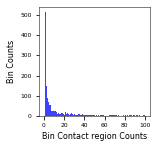

In [21]:
# Bin Inter countacts
# Enrichment score distribution
plt.figure(figsize=(2,2))
iContacts = PCMatrix.sum() - 1 # minus self contact
plt.hist(iContacts,bins=100,range=[0,100], histtype='bar',facecolor='blue',alpha=0.75)
plt.ylabel("Bin Counts")
plt.xlabel("Bin Contact region Counts")
#plt.yscale('log')
#plt.show()
plt.savefig("Inter_chromosome_bincontacts_targets.pdf")

In [22]:
iContacts.describe()

count    1803.000000
mean       46.214088
std        76.950628
min         1.000000
25%         1.000000
50%         6.000000
75%        49.000000
max       912.000000
dtype: float64

In [23]:
# Contact Pairs filter 2  Contact bins 
'''
bin contact with other chromosome bins more than 20
'''
bin_num = 20
cluster_P = PCMatrix.T.sum() >= bin_num
print( sum(cluster_P) )
PCMatrix_filter = PCMatrix.loc[cluster_P, cluster_P]
#column_filter = PCMatrix_filter.sum() >= 30
#print( sum(column_filter) ) 
#PCMatrix_filter = PCMatrix_filter.loc[:, column_filter]
PCMatrix_filter

664


,chr20_1,chr7_2,chr21_29,chr16_84,chr20_55,chr19_30,chr11_63,chr1_36,chr19_2,chr17_40,...,chr16_35,chr19_9,chr11_64,chr12_3,chr1_151,chr4_5,chr2_231,chr22_47,chr16_87,chr12_2
chr20_1,1,0,0,1,0,0,1,1,0,1,...,0,0,1,1,0,1,0,1,1,1
chr7_2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chr21_29,0,0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chr16_84,1,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
chr20_55,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr4_5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,1
chr2_231,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
chr22_47,1,0,0,0,0,1,0,1,0,1,...,0,0,0,1,0,1,0,1,1,1
chr16_87,1,0,0,0,0,0,1,0,0,1,...,0,0,1,1,0,0,0,1,1,1


In [24]:
# Contact Pairs filter 2  Contact bins 
'''
bin contact with other chromosome bins more than 20(previous steps)
'''
filter_bintags = PCMatrix_filter.index.to_list()
binC_P = ( BP_freqTrue.bin1tag.isin(filter_bintags) ) & ( BP_freqTrue.bin2tag.isin(filter_bintags) )
BP_freqEnrich = BP_freqTrue.loc[binC_P, :]
BP_freqEnrich

,bin1tag,bin2tag,Freq,Prob,EnrichS,p_value,p_adjusted
15,chr10_100,chr11_71,84,0.0,2.444824,3.780313e-13,1.538494e-06
16,chr10_100,chr11_72,88,0.0,2.561245,8.771575e-15,3.569815e-08
17,chr10_100,chr11_74,141,0.0,4.103812,1.029799e-42,4.191029e-36
18,chr10_100,chr12_0,118,0.0,3.434396,2.650895e-29,1.078849e-22
19,chr10_100,chr12_1,85,0.0,2.473929,1.500849e-13,6.108087e-07
...,...,...,...,...,...,...,...
41652,chr8_143,chr9_137,349,0.0,10.157663,0.000000e+00,0.000000e+00
41655,chr8_28,chr9_127,79,0.0,2.299299,3.211656e-11,1.307065e-04
41656,chr8_28,chr9_34,107,0.0,3.114241,1.502884e-23,6.116367e-17
41657,chr8_28,chr9_35,90,0.0,2.619455,1.249387e-15,5.084699e-09


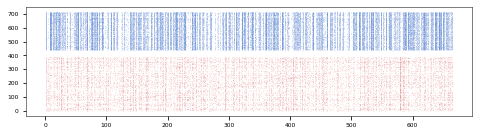

In [25]:
# 计算Gaussian Cluster
import numpy as np
from numpy import unique
from sklearn.mixture import GaussianMixture

X = np.array(PCMatrix_filter)
n_clusters_ = 2
model = GaussianMixture(n_components=n_clusters_, random_state=10)
model.fit(X)
lables  = model.predict(X)

plt.figure(figsize=(8, 2))
plt.clf()
#colors = cycle('rbcmykbgrcmykbgrcmykbgrcmyk')
colors = "rbcmykbgrcmykbgrcmykbgrcmyk"
np = 0
Xplist = pd.Series( [i+1 for i in range(len(PCMatrix_filter) ) ] )
for k, col in zip(range(n_clusters_), colors):
    ##根据lables中的值是否等于k，重新组成一个True、False的数组
    my_members = lables == k
    gdf = PCMatrix_filter.loc[my_members, :] 
    ##X[my_members, 0] 取出my_members对应位置为True的值的横坐标
    for n, rowvalue in gdf.iterrows():
        cp = rowvalue > 0 
        X = Xplist.loc[cp.to_list()].to_list()
        Y = len(X)*[np]
        plt.plot(X, Y, col + '.', markersize=0.5)
        np += 1
    np += 50


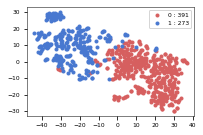

In [26]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform( PCMatrix_filter ) 

plt.figure(figsize=(3, 2))
colors = 'r', 'b', 'g', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
target_ids = range(n_clusters_)

legendlist = []
for i, c, label in zip(target_ids, colors, target_ids):
    plt.scatter(X_2d[lables == i, 0], X_2d[lables == i, 1], c=c, label=label)
    legendlist.append("%d : %d"%(i, sum(lables==i) ) )
plt.legend(legendlist)
#plt.show()
plt.savefig("GaussianMixture.2cluster.pdf")

In [30]:
# Tsne dataframe
tSNE_df = pd.DataFrame(X_2d)
tSNE_df["bintags"] = PCMatrix_filter.index
tSNE_df["Cluster"] = lables
tSNE_df.columns = ["tsne1", "tsne2", "bintags", "Cluster"]
tSNE_df

,tsne1,tsne2,bintags,Cluster
0,-42.676746,14.030536,chr20_1,1
1,9.067137,-3.720621,chr7_2,0
2,25.112129,-17.126551,chr21_29,0
3,27.752138,0.131015,chr16_84,0
4,22.978537,-15.572381,chr20_55,0
...,...,...,...,...
659,22.291927,-1.515085,chr4_5,0
660,6.212742,1.712636,chr2_231,0
661,-1.635320,-22.501024,chr22_47,0
662,-16.711895,-5.129459,chr16_87,1


,Cluster,bintags,Positive_rate,Positive_Freq
414,0,chr10_100,0.224719,20
350,1,chr10_101,0.867925,184
312,1,chr10_102,0.889706,121
346,0,chr10_13,0.266667,12
454,0,chr10_132,0.428571,9
...,...,...,...,...
109,0,chr9_92,0.444444,16
402,0,chr9_93,0.301370,22
568,0,chr9_94,0.114286,4
498,0,chr9_95,0.250000,6


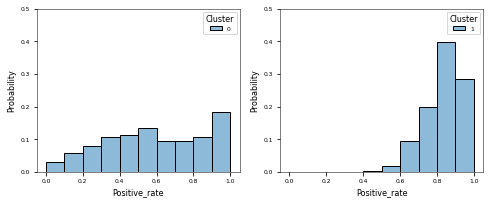

In [31]:
# Hub Clusters
'''
Hub Cluster assign and filter
## Positive and Negative contacts
'''
HubCluster_df = pd.DataFrame({"Cluster" : lables,
                             "bintags" : PCMatrix_filter.index.to_list()} )
HubCluster_df = HubCluster_df.sort_values(by = ["bintags", "Cluster"] )
HubCluster_df.head(10)

def GetbintagInformations(df, chrombin_df = chrombin_df): # Get bintag informations
    try:
        chrombin_df = chrombin_df.set_index("bintag", drop=False)
    except:
        pass
    df.loc[:, "bin1_chrom"] = df.bin1tag.apply( lambda x: chrombin_df.loc[x,"chrom"] )
    df.loc[:, "bin1_start"] = df.bin1tag.apply( lambda x: chrombin_df.loc[x,"start"] )
    df.loc[:, "bin1_end"] = df.bin1tag.apply( lambda x: chrombin_df.loc[x,"end"] )
    df.loc[:, "bin2_chrom"] = df.bin2tag.apply( lambda x: chrombin_df.loc[x,"chrom"] )
    df.loc[:, "bin2_start"] = df.bin2tag.apply( lambda x: chrombin_df.loc[x,"start"] )
    df.loc[:, "bin2_end"] = df.bin2tag.apply( lambda x: chrombin_df.loc[x,"end"] ) 
    return(df)

# Filter Hubs
### Calculate hub contact positive 
HubCluster_df.loc[:, "Positive_rate"] = 0
HubCluster_df.loc[:, "Positive_Freq"] = 0
pos_rate, pos_freq = [], []
for n, rowvalue in HubCluster_df.iterrows():
    cluster, bintag = rowvalue["Cluster"], rowvalue["bintags"]
    bintagP =  (BP_freqTrue.bin1tag==bintag) | (BP_freqTrue.bin2tag==bintag)
    allC_count = sum( bintagP  ) # bintag contacts
    ## cluter positive (with the same cluster) cbins count
    cbins = HubCluster_df.loc[HubCluster_df.Cluster == cluster, "bintags"].to_list()
    cP = BP_freqTrue.bin1tag.isin(cbins) & BP_freqTrue.bin2tag.isin(cbins)
    pos_count = sum( bintagP  & cP )
    pos_rate.append( float(pos_count/allC_count) )
    pos_freq.append( int(pos_count) )
HubCluster_df.loc[:, "Positive_rate"] = pos_rate
HubCluster_df.loc[:, "Positive_Freq"] = pos_freq


## Hub Cluster bin positive contact (with in the same class) 
plt.figure(figsize=(4*n_clusters_ ,3))
for cluster in range(0, n_clusters_):
    plt.subplot(1, n_clusters_ ,cluster+1)
    sns.histplot( HubCluster_df.loc[HubCluster_df.Cluster==cluster, :],
                x = "Positive_rate",
                hue = "Cluster",
                multiple = "layer",
                bins = 10,
                binrange = [0, 1],
                stat  = "probability")
    plt.ylim([0, 0.5])

HubCluster_df

In [38]:
# Filter HubCluster_df 
HubCluster_Filter = HubCluster_df.loc[HubCluster_df.Positive_rate>=0.90, :]
print(HubCluster_Filter.head(10) )

# Export Hub bins
## Export Hub cluter bin information
chrombin_df.loc[:, "Enrichment_bins"] = 0
chrombin_df.loc[PCMatrix_filter.index.to_list(),"Enrichment_bins"] = 1

chrombin_df.loc[:, "HubType"] = 3
chrombin_df.loc[:, "HubTypes"] = "Other" 
for cluster, gdf in HubCluster_Filter.groupby("Cluster"):
    cbins = gdf.bintags.to_list() # Cluster bins
    chrombin_df.loc[cbins, "HubType"] = cluster
    chrombin_df.loc[cbins, "HubTypes"] = "Cluster %d"%(cluster + 1)
print( chrombin_df.HubType.value_counts(normalize=True) )

export_cols = ["chrom", "start", "end", "Enrichment_bins", "HubTypes"]
Export_file = "/data1/ZJY/Pore-C/Analysis/Jupyter/Figures/Inter_Chromosome/Genome_Hub_bins.txt"
chrombin_df.loc[:, export_cols].to_csv(Export_file, sep="\t", header=False, index=False)

# Export Hub Cluster Interaction
color_dict = {0:"0,0,255", 1:"255,0,0"}
clist = []
for cluster, gdf in HubCluster_Filter.groupby("Cluster"):
    cbins = gdf.bintags.to_list() # Cluster bins
    cP = BP_freqTrue.bin1tag.isin(cbins) & BP_freqTrue.bin2tag.isin(cbins)
    Cluster_df =  BP_freqTrue.loc[cP, :] # Cluster pair contact dataframe 
    Cluster_df = GetbintagInformations( Cluster_df )
    Cluster_df.loc[:, "Color"] = color_dict[cluster]
    #clist.append(Cluster_df)
    #Cluster_df = pd.concat(clist)
    export_cols = ["bin1_chrom", "bin1_start", "bin1_end", "bin2_chrom", "bin2_start", "bin2_end", "Color"]
    Export_file = "/data1/ZJY/Pore-C/Analysis/Jupyter/Figures/Inter_Chromosome/Cluster%s_hub_contacts_filter.txt"%cluster
    Cluster_df.loc[:, export_cols].to_csv(Export_file, sep="\t", header=False, index=False)

     Cluster    bintags  Positive_rate  Positive_Freq
120        0   chr10_42       0.952381             20
656        1   chr11_64       0.903553            178
621        1   chr11_65       0.956989            178
23         1   chr11_66       0.939891            172
459        1   chr11_67       0.930736            215
637        1  chr12_121       0.902857            158
32         1   chr12_49       0.943820            168
172        1   chr12_50       0.925743            187
583        0   chr14_19       0.936170             44
36         0   chr14_24       0.916667             33
3    0.950723
1    0.025624
0    0.023653
Name: HubType, dtype: float64


/home/zyserver/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/zyserver/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/zyserver/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

In [34]:
HubCluster_Filter

,Cluster,bintags,Positive_rate,Positive_Freq
120,0,chr10_42,0.952381,20
656,1,chr11_64,0.903553,178
621,1,chr11_65,0.956989,178
23,1,chr11_66,0.939891,172
459,1,chr11_67,0.930736,215
...,...,...,...,...
198,1,chr6_42,0.937888,151
262,1,chr7_74,0.962617,103
385,1,chr9_128,0.927350,217
12,1,chr9_129,0.906883,224


In [53]:
# Cluster hub filter bins
tSNE_df["HubFilter"] = 0
tSNE_df.loc[tSNE_df.bintags.isin(HubCluster_Filter["bintags"].to_list()), "HubFilter"] = 1
tSNE_df

,tsne1,tsne2,bintags,Cluster,HubFilter
0,12.025361,-42.362190,chr1_123,0,0
1,0.837529,9.667629,chr1_16,1,0
2,6.012460,-20.818893,chr20_41,0,0
3,-2.078502,-31.918421,chr20_23,0,0
4,-24.495987,-16.540777,chr2_238,0,0
...,...,...,...,...,...
659,2.451151,-28.081144,chr20_13,0,1
660,-7.168147,-10.224319,chr12_12,0,0
661,-0.335276,-31.370041,chr17_54,0,0
662,9.093944,-30.975666,chr18_14,0,0


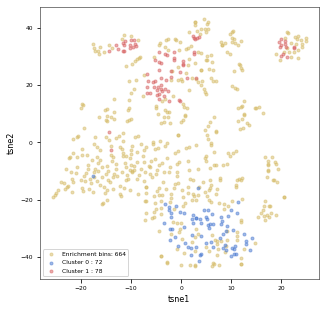

In [54]:
# Hub cluster bins tsne
plt.figure(figsize=(5, 5))
colors = 'b', 'r', 'g', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
target_ids = range(n_clusters_)

legendlist = []
# Enrichment bins
plt.scatter(tSNE_df.loc[tSNE_df.HubFilter==0, "tsne1"].values, 
            tSNE_df.loc[tSNE_df.HubFilter==0, "tsne2"].values,
            c="y", alpha=0.5)
legendlist.append("Enrichment bins: %d"%( len(tSNE_df) ) )
# Cluster bins
for i, c, label in zip(target_ids, colors, target_ids):
    plt.scatter(X_2d[(lables == i)&(tSNE_df.HubFilter==1), 0], 
                X_2d[(lables == i)&(tSNE_df.HubFilter==1), 1],
                c=c, label=label, alpha=0.5)
    legendlist.append("Cluster %d : %d"%(i, sum( (lables == i)&(tSNE_df.HubFilter==1) ) ) )

plt.xlabel("tsne1")
plt.ylabel("tsne2")
        
plt.legend(legendlist)
plt.savefig("HubCluster_tsne_figure.pdf")
#plt.show()

In [43]:
# Export Hub Cluster Interaction (Positive Hub cluster bins)
import numpy as np
def ColorValue(x, maxvalue):
    '''
    1. Log scale scores
    2. max scores indicated as red
    3. 
    '''
    cV = int(255*x/maxvalue)
    return("%d,%d,%d"%(cV,0,0) )
clist = []
for cluster, gdf in HubCluster_Filter.groupby("Cluster"):
    cbins = gdf.bintags.to_list() # Cluster bins
    cP = BP_freqTrue.bin1tag.isin(cbins) & BP_freqTrue.bin2tag.isin(cbins)
    Cluster_df =  BP_freqTrue.loc[cP, :] # Cluster pair contact dataframe 
    Cluster_df = GetbintagInformations( Cluster_df )
    #Cluster_df.loc[:, "Color"] = color_dict[cluster]
    maxS = np.log2( Cluster_df.EnrichS.max() )
    Cluster_df.loc[:, "Color"] =  Cluster_df.EnrichS.apply( lambda x:  ColorValue(np.log2(x), maxS) )
    #clist.append(Cluster_df)
    #Cluster_df = pd.concat(clist)
    export_cols = ["bin1_chrom", "bin1_start", "bin1_end", "bin2_chrom", "bin2_start", "bin2_end", "Color"]
    Export_file = "/data1/ZJY/Pore-C/Analysis/Jupyter/Figures/Inter_Chromosome/Cluster%s_hub_contacts_filter.txt"%cluster
    Cluster_df.loc[:, export_cols].to_csv(Export_file, sep="\t", header=False, index=False)

/home/zyserver/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/zyserver/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [80]:
# Export Inter-chromosome interaction
def ExportEnrichS(chrombin_df, enrich_df, Export_file):
    BP_freq_filter = enrich_df 
    # Get bintag informations
    BP_freq_filter.loc[:, "bin1_chrom"] = BP_freq_filter.bin1tag.apply( lambda x: chrombin_df.loc[x,"chrom"] )
    BP_freq_filter.loc[:, "bin1_start"] = BP_freq_filter.bin1tag.apply( lambda x: chrombin_df.loc[x,"start"] )
    BP_freq_filter.loc[:, "bin1_end"] = BP_freq_filter.bin1tag.apply( lambda x: chrombin_df.loc[x,"end"] )
    BP_freq_filter.loc[:, "bin2_chrom"] = BP_freq_filter.bin2tag.apply( lambda x: chrombin_df.loc[x,"chrom"] )
    BP_freq_filter.loc[:, "bin2_start"] = BP_freq_filter.bin2tag.apply( lambda x: chrombin_df.loc[x,"start"] )
    BP_freq_filter.loc[:, "bin2_end"] = BP_freq_filter.bin2tag.apply( lambda x: chrombin_df.loc[x,"end"] )
    # get color
    maxS = np.log2(BP_freq_filter.EnrichS.max() )
    BP_freq_filter.loc[:, "Color"] =  BP_freq_filter.EnrichS.apply( lambda x:  ColorValue(np.log2(x), maxS) )
    # Export
    export_cols = ["bin1_chrom", "bin1_start", "bin1_end", "bin2_chrom", "bin2_start", "bin2_end", "Color", 
                   "Freq", "Prob", "EnrichS", "p_value", "p_adjusted"]
    BP_freq_filter.loc[:, export_cols].to_csv(Export_file, sep="\t", header=False, index=False)
    return (BP_freq_filter)

Export_file = "/data1/ZJY/Pore-C/Analysis/Jupyter/Figures/Inter_Chromosome/Enrichment_contact.txt"
export_freqEnrich = ExportEnrichS(chrombin_df, BP_freqEnrich, Export_file)

/home/zyserver/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/zyserver/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


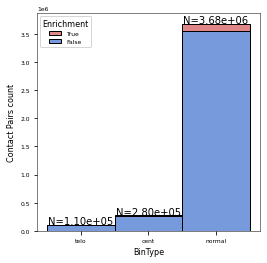

In [46]:
# BinType Selection and Comparision
#import scipy.stats as stats
#import random
#number = 100
Esthred, p_thred = 2, 0.01

def GetSelectEnrichS(selectType, selebins, pairtype="or"):
    ## contact pair tag1, tag2
    #P1 = BP_freqEnrich.bin1tag.isin(selebins)
    #P2 = BP_freqEnrich.bin2tag.isin(selebins)
    P1 = BP_freq.bin1tag.isin(selebins)
    P2 = BP_freq.bin2tag.isin(selebins)
    if pairtype=="or":
        P = (P1 | P2)
    else:
        P = (P1 & P2)
    #select_EnrichS = BP_freqEnrich.loc[P, "EnrichS"].to_list()
    #p_adj = BP_freqEnrich.loc[P, "p_adjusted"].to_list()
    select_EnrichS = BP_freq.loc[P, "EnrichS"].to_list()
    p_adj = BP_freq.loc[P, "p_adjusted"].to_list()
    bin1tag, bin2tag = BP_freq.loc[P, "bin1tag"].to_list(), BP_freq.loc[P, "bin2tag"].to_list()
    ## In each group
    #SGroup_Dict[selectType] = select_EnrichS 
    ## Merge
    MergeS_Dict["BinType"].extend( len(select_EnrichS)*[selectType] )
    MergeS_Dict["EnrichS"].extend( select_EnrichS )
    MergeS_Dict["p_adjusted"].extend( p_adj )
    MergeS_Dict["bin1tag"].extend( bin1tag )
    MergeS_Dict["bin2tag"].extend( bin2tag )
    return
    
#SGroup_Dict = {}
MergeS_Dict = {"BinType": [],
               "EnrichS":[],
               "p_adjusted":[],
              "bin1tag":[],
              "bin2tag":[]}

#chrombin_df = chrombin_df.reset_index()
# Telo, centro, normal  
for selectType in ["telo", "cent"]:
    selebins = chrombin_df.loc[chrombin_df.binType == selectType, "bintag"].to_list()
    GetSelectEnrichS(selectType, selebins, "or")

## not telo and centro
selectType = "normal"
selebins = chrombin_df.loc[chrombin_df.binType == selectType, "bintag"].to_list()
GetSelectEnrichS(selectType, selebins, "and")

MergeS_df = pd.DataFrame(MergeS_Dict)
# Enrichment define
MergeS_df["Enrichment"] = False
MergeS_df.loc[(MergeS_df.EnrichS>Esthred ) &(MergeS_df.p_adjusted <p_thred), "Enrichment"] = True

plt.figure(figsize=(4,4))
sns.histplot(MergeS_df,
            x = "BinType",
            stat = "count",
            hue = "Enrichment", hue_order = [ True, False],
            palette = ["r","b"],  multiple = 'stack' )
xdict = {"telo":0,
        "cent":1,
        "normal":2 }
for BinType, gdf in  MergeS_df.groupby("BinType"):
    N = len(gdf)
    #EnrichNum = sum(gdf.Enrichment == "True")
    #plt.text( xdict[BinType], N, "N=%.3e\n( %.3e )"%(N, EnrichNum), 
    #         ha="center", fontsize=8 )
    plt.text( xdict[BinType], N+1000, "N=%.2e"%N, ha="center", fontsize=10 )
plt.ylabel("Contact Pairs count")
plt.savefig("Contact_bintypes_count_v1.pdf")

In [47]:
MergeS_df

,BinType,EnrichS,p_adjusted,bin1tag,bin2tag,Enrichment
0,telo,3.841867,1.196942e-30,chr10_0,chr11_0,True
1,telo,1.891828,1.000000e+00,chr10_0,chr11_1,False
2,telo,1.629883,1.000000e+00,chr10_0,chr11_10,False
3,telo,1.164202,1.000000e+00,chr10_0,chr11_100,False
4,telo,0.960467,1.000000e+00,chr10_0,chr11_101,False
...,...,...,...,...,...,...
4073478,normal,0.582101,1.000000e+00,chr9_99,chrX_95,False
4073479,normal,0.669416,1.000000e+00,chr9_99,chrX_96,False
4073480,normal,0.582101,1.000000e+00,chr9_99,chrX_97,False
4073481,normal,0.378366,1.000000e+00,chr9_99,chrX_98,False


In [48]:
BP_freqEnrich

,bin1tag,bin2tag,Freq,Prob,EnrichS,p_value,p_adjusted
15,chr10_100,chr11_71,84,0.0,2.444824,3.780313e-13,1.538494e-06
16,chr10_100,chr11_72,88,0.0,2.561245,8.771575e-15,3.569815e-08
17,chr10_100,chr11_74,141,0.0,4.103812,1.029799e-42,4.191029e-36
18,chr10_100,chr12_0,118,0.0,3.434396,2.650895e-29,1.078849e-22
19,chr10_100,chr12_1,85,0.0,2.473929,1.500849e-13,6.108087e-07
...,...,...,...,...,...,...,...
41652,chr8_143,chr9_137,349,0.0,10.157663,0.000000e+00,0.000000e+00
41655,chr8_28,chr9_127,79,0.0,2.299299,3.211656e-11,1.307065e-04
41656,chr8_28,chr9_34,107,0.0,3.114241,1.502884e-23,6.116367e-17
41657,chr8_28,chr9_35,90,0.0,2.619455,1.249387e-15,5.084699e-09


In [49]:
MergeS_df

,BinType,EnrichS,p_adjusted,bin1tag,bin2tag,Enrichment
0,telo,3.841867,1.196942e-30,chr10_0,chr11_0,True
1,telo,1.891828,1.000000e+00,chr10_0,chr11_1,False
2,telo,1.629883,1.000000e+00,chr10_0,chr11_10,False
3,telo,1.164202,1.000000e+00,chr10_0,chr11_100,False
4,telo,0.960467,1.000000e+00,chr10_0,chr11_101,False
...,...,...,...,...,...,...
4073478,normal,0.582101,1.000000e+00,chr9_99,chrX_95,False
4073479,normal,0.669416,1.000000e+00,chr9_99,chrX_96,False
4073480,normal,0.582101,1.000000e+00,chr9_99,chrX_97,False
4073481,normal,0.378366,1.000000e+00,chr9_99,chrX_98,False


In [50]:
from scipy import stats

def GetSelectInteractions(selebins,  df, pairtype="or"):
    ## contact pair tag1, tag2
    P1 = df.bin1tag.isin(selebins)
    P2 = df.bin2tag.isin(selebins)
    if pairtype=="or":
        P = (P1 | P2)
    elif pairtype=="and":
        P = (P1 & P2)
    elif pairtype == "one_tail":
        P = (P1 | P2) & ~(P1 & P2)
    return( sum(P) )

def TypeEnrichmentP_value(TypeEnrichs, TypeInterActions, s_Posibility):
    NumTypes = len(BP_freq)
    k = TypeEnrichs
    # significat Posibility
    #s_Posibility = float( len(BP_freqEnrich) / len(BP_freq) )
    X = np.arange(k, TypeInterActions, 1)
    #pList = stats.binom.pmf(X, len(BP_freq), s_Posibility)
    pList = stats.binom.pmf(X, len(BP_freq), s_Posibility)
    p_value = sum(pList) # p_value
    return(p_value)
    

# Telo, centro, normal   双端 telo, centro
for selectType in ["telo", "cent","normal"]:
    selebins = chrombin_df.loc[chrombin_df.binType == selectType, "bintag"].to_list()
    #selebins = chrombin_df.loc[chrombin_df.binType == selectType].index.to_list()
    andor = "or"
    if selectType == "normal":
        andor = "and"
        
    Edf = BP_freqEnrich
    TypeInterActions = GetSelectInteractions( selebins, BP_freq  , andor)
    TypeEnrichs = GetSelectInteractions( selebins, Edf , andor)
    s_Posibility = float( len(Edf) / len(BP_freq) )
    #TypeEnrichs = GetSelectInteractions( selebins, BP_freqEnrich , andor)
    #TypeEnrichs = GetSelectInteractions( selebins, BP_freqTrue , andor) BP_freq_Filter
    #p_value = TypeEnrichmentP_value(TypeEnrichs, TypeInterActions, s_Posibility)
    p_value = 0.0
    print(selectType, p_value, TypeEnrichs, TypeInterActions, float(TypeEnrichs/TypeInterActions), len(BP_freq) , s_Posibility )

# Telo, centro, normal   单双端 telo, centro
for selectType in ["telo", "cent"]:
    selebins = chrombin_df.loc[chrombin_df.binType == selectType, "bintag"].to_list()
    #selebins = chrombin_df.loc[chrombin_df.binType == selectType].index.to_list()
    andor = "one_tail"
    
    Edf = BP_freqEnrich
    TypeInterActions = GetSelectInteractions( selebins, BP_freq  , andor)
    TypeEnrichs = GetSelectInteractions( selebins, Edf , andor)
    s_Posibility = float( len(Edf) / len(BP_freq) )
    #TypeEnrichs = GetSelectInteractions( selebins, BP_freqEnrich , andor)
    #TypeEnrichs = GetSelectInteractions( selebins, BP_freqTrue , andor) BP_freq_Filter
    #p_value = TypeEnrichmentP_value(TypeEnrichs, TypeInterActions, s_Posibility)
    p_value = 0.0
    print(selectType, p_value, TypeEnrichs, TypeInterActions, float(TypeEnrichs/TypeInterActions), len(BP_freq) , s_Posibility )


telo 0.0 2000 109941 0.018191575481394565 4069754 0.00921996759509297
cent 0.0 889 279739 0.003177962314872077 4069754 0.00921996759509297
normal 0.0 34654 3683803 0.00940712627683945 4069754 0.00921996759509297
telo 0.0 1959 109179 0.01794301101860248 4069754 0.00921996759509297
cent 0.0 821 274561 0.002990228036756859 4069754 0.00921996759509297


In [51]:
BP_freq

,bin1tag,bin2tag,Freq,Prob,EnrichS,p_value,p_adjusted
0,chr10_0,chr11_0,132,0.000000e+00,3.841867,2.941068e-37,1.196942e-30
1,chr10_0,chr11_1,65,0.000000e+00,1.891828,1.484266e-06,1.000000e+00
2,chr10_0,chr11_10,56,0.000000e+00,1.629883,3.350620e-04,1.000000e+00
3,chr10_0,chr11_100,40,0.000000e+00,1.164202,1.717350e-01,1.000000e+00
4,chr10_0,chr11_101,33,7.634368e-35,0.960467,5.910600e-01,1.000000e+00
...,...,...,...,...,...,...,...
4069749,chr9_99,chrX_95,20,4.144332e-15,0.582101,9.962510e-01,1.000000e+00
4069750,chr9_99,chrX_96,23,0.000000e+00,0.669416,9.808760e-01,1.000000e+00
4069751,chr9_99,chrX_97,20,4.144332e-15,0.582101,9.962510e-01,1.000000e+00
4069752,chr9_99,chrX_98,13,2.023359e-06,0.378366,9.999871e-01,1.000000e+00


In [52]:
# Export Telo and Centromere Enrichment Contact pairs
Esthred, p_thred = 2, 0.01
# Set color
def ColorValue(x, maxvalue):
    '''
    1. Log scale scores
    2. max scores indicated as red
    '''
    cV = int(255*x/maxvalue)
    return("%d,%d,%d"%(cV,0,0) )

def ExportSelectEnrichS(Tagname, selebins, chrombin_df, pairtype="or"):
    ## contact pair tag1, tag2
    P1 = BP_freqEnrich.bin1tag.isin(selebins)
    P2 = BP_freqEnrich.bin2tag.isin(selebins)
    if pairtype=="or":
        P = (P1 | P2)
    elif pairtype=="and":
        P = (P1 & P2)
    elif pairtype == "one_tail":
        P = (P1 | P2) & ~(P1 & P2)
        
    BP_freq_filter = BP_freqEnrich.loc[P, :]    
    # Enrichment
    #eP = (BP_freqTrue.EnrichS >= Esthred) & (BP_freqTrue.p_adjusted < p_thred )
    ## filter
    #BP_freq_filter = BP_freqTrue.loc[P&eP, :]
    # Get bintag informations
    BP_freq_filter.loc[:, "bin1_chrom"] = BP_freq_filter.bin1tag.apply( lambda x: chrombin_df.loc[x,"chrom"] )
    BP_freq_filter.loc[:, "bin1_start"] = BP_freq_filter.bin1tag.apply( lambda x: chrombin_df.loc[x,"start"] )
    BP_freq_filter.loc[:, "bin1_end"] = BP_freq_filter.bin1tag.apply( lambda x: chrombin_df.loc[x,"end"] )
    BP_freq_filter.loc[:, "bin2_chrom"] = BP_freq_filter.bin2tag.apply( lambda x: chrombin_df.loc[x,"chrom"] )
    BP_freq_filter.loc[:, "bin2_start"] = BP_freq_filter.bin2tag.apply( lambda x: chrombin_df.loc[x,"start"] )
    BP_freq_filter.loc[:, "bin2_end"] = BP_freq_filter.bin2tag.apply( lambda x: chrombin_df.loc[x,"end"] )
    # get color
    maxS = np.log2(BP_freq_filter.EnrichS.max() )
    BP_freq_filter.loc[:, "Color"] =  BP_freq_filter.EnrichS.apply( lambda x:  ColorValue(np.log2(x), maxS) )
    # Export
    export_cols = ["bin1_chrom", "bin1_start", "bin1_end", "bin2_chrom", "bin2_start", "bin2_end", "Color"]
    Export_file = "/data1/ZJY/Pore-C/Analysis/Jupyter/Figures/Inter_Chromosome/%s_Enrichment_contact_one_tail.txt"%(Tagname)
    BP_freq_filter.loc[:, export_cols].to_csv(Export_file, sep="\t", header=False, index=False)
    
    # Export bins
    ## Export all telo, centro bins
    bintags =  BP_freq_filter.bin1tag.to_list() 
    bintags.extend( BP_freq_filter.bin2tag.to_list()  )
    bintags = set(bintags)
    print("There are %d bins of enrich intere chromosome interactions"%len(bintags) )
    ##  telo and centro enrichment bins
    P = chrombin_df.bintag.isin(bintags) 
    select_df = chrombin_df.loc[P, :]
    Export_file2 = "/data1/ZJY/Pore-C/Analysis/Jupyter/Figures/Inter_Chromosome/bins_%s_Enrichment_contact_one_tail.txt"%(Tagname)
    select_df.to_csv(Export_file2, sep="\t", header=False, index=False)
    return (BP_freq_filter)

# 颜色转换 白色（255,255,255） 黑色（0,0,0）, red(255,0,0)
#chrombin_df = chrombin_df.set_index("bintag",drop=False)
# Telo, centro, normal  
for selectType in ["telo", "cent"]:
    selebins = chrombin_df.loc[chrombin_df.binType == selectType].bintag.to_list()
    BP_freq_filter = ExportSelectEnrichS(selectType, selebins, chrombin_df, "one_tail")
    print(selectType, BP_freq_filter )

There are 549 bins of enrich intere chromosome interactions
telo          bin1tag   bin2tag  Freq  Prob    EnrichS       p_value    p_adjusted  \
18     chr10_100   chr12_0   118   0.0   3.434396  2.650895e-29  1.078849e-22   
107    chr10_101   chr12_0   115   0.0   3.347081  1.091290e-27  4.441282e-21   
150    chr10_101   chr17_0    92   0.0   2.677665  1.703835e-16  6.934189e-10   
194    chr10_101   chr20_0   105   0.0   3.056030  1.487226e-22  6.052642e-16   
248    chr10_101    chr7_0    77   0.0   2.241089  1.743729e-10  7.096548e-04   
...          ...       ...   ...   ...        ...           ...           ...   
41542     chr7_0  chr9_133   139   0.0   4.045602  1.766379e-41  7.188726e-35   
41543     chr7_0  chr9_134   157   0.0   4.569493  5.151423e-53  2.096502e-46   
41544     chr7_0  chr9_135   226   0.0   6.577742  0.000000e+00  0.000000e+00   
41545     chr7_0  chr9_136   163   0.0   4.744124  4.610912e-57  1.876528e-50   
41546     chr7_0  chr9_137   495   0.0  14.4

/home/zyserver/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/zyserver/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/zyserver/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

In [53]:
BP_freqTrue

,bin1tag,bin2tag,Freq,Prob,EnrichS,p_value,p_adjusted
0,chr10_0,chr16_4,75,0.0,2.182879,9.002678e-10,3.663869e-03
1,chr10_0,chr18_49,79,0.0,2.299299,3.211656e-11,1.307065e-04
2,chr10_0,chr20_3,97,0.0,2.823190,9.730645e-19,3.960133e-12
3,chr10_0,chr20_51,96,0.0,2.794085,2.791061e-18,1.135893e-11
4,chr10_0,chr21_32,121,0.0,3.521711,5.971939e-31,2.430432e-24
...,...,...,...,...,...,...,...
41657,chr8_28,chr9_35,90,0.0,2.619455,1.249387e-15,5.084699e-09
41658,chr8_28,chr9_36,107,0.0,3.114241,1.502884e-23,6.116367e-17
41659,chr8_29,chr9_36,91,0.0,2.648560,4.638725e-16,1.887847e-09
41660,chr8_99,chr9_125,91,0.0,2.648560,4.638725e-16,1.887847e-09


In [54]:
BP_freqEnrich

,bin1tag,bin2tag,Freq,Prob,EnrichS,p_value,p_adjusted
15,chr10_100,chr11_71,84,0.0,2.444824,3.780313e-13,1.538494e-06
16,chr10_100,chr11_72,88,0.0,2.561245,8.771575e-15,3.569815e-08
17,chr10_100,chr11_74,141,0.0,4.103812,1.029799e-42,4.191029e-36
18,chr10_100,chr12_0,118,0.0,3.434396,2.650895e-29,1.078849e-22
19,chr10_100,chr12_1,85,0.0,2.473929,1.500849e-13,6.108087e-07
...,...,...,...,...,...,...,...
41652,chr8_143,chr9_137,349,0.0,10.157663,0.000000e+00,0.000000e+00
41655,chr8_28,chr9_127,79,0.0,2.299299,3.211656e-11,1.307065e-04
41656,chr8_28,chr9_34,107,0.0,3.114241,1.502884e-23,6.116367e-17
41657,chr8_28,chr9_35,90,0.0,2.619455,1.249387e-15,5.084699e-09


In [55]:
# tRNA and rDNA Enrichments
## tRNA
bed_file = "/data1/ZJY/Pore-C/Analysis/Jupyter/Figures/Inter_Chromosome/Annotation/UCSC_tRNA_genes.bed"
tRNA_df = pd.read_csv(bed_file, sep="\t", 
                      header=None, 
                      index_col=None, 
                      names=["chrom", "start", "end"], usecols = [0,1,2])
bed_file = "/data1/ZJY/Pore-C/Analysis/Jupyter/Figures/Inter_Chromosome/Annotation/ensemble_rRNA_genes.bed"
rDNA_df = pd.read_csv(bed_file, sep="\t", 
                      header=None, 
                      index_col=None, 
                      names=["chrom", "start", "end"], usecols = [0,1,2])
## tRNA rDNA bintags
tRNA_df.loc[:, "bintag"] = binIDtag(tRNA_df.chrom.values, tRNA_df.start.values, 1000000)
rDNA_df.loc[:, "bintag"] = binIDtag(rDNA_df.chrom.values, rDNA_df.start.values, 1000000)


# tRNA , rDNA 
for selectType in ["tRNA", "rDNA"]:
    if selectType == "tRNA":
        selebins = tRNA_df.bintag.to_list()
    elif selectType == "rDNA":
        selebins = rDNA_df.bintag.to_list()
    #selebins = chrombin_df.loc[chrombin_df.binType == selectType, "bintag"].to_list()
    andor = "and"
    Edf = BP_freqTrue
    #Edf = BP_freq_Filter
    s_Posibility = float( len(Edf) / len(BP_freq) )
    TypeInterActions = GetSelectInteractions( selebins, BP_freq  , andor)
    TypeEnrichs = GetSelectInteractions( selebins, Edf, andor)
    #TypeEnrichs = GetSelectInteractions( selebins, BP_freqEnrich , andor)
    p_value = TypeEnrichmentP_value(TypeEnrichs, TypeInterActions, s_Posibility)
    print(selectType, p_value, TypeEnrichs, TypeInterActions, float(TypeEnrichs/TypeInterActions), len(BP_freq), len(Edf) , s_Posibility )


tRNA 0.0 541 19110 0.028309785452642594 4069754 41662 0.010236982382718956
rDNA 1.0 1156 84814 0.013629825264696867 4069754 41662 0.010236982382718956


In [56]:
# tRNA and rDNA Enrichment Calculate
'''
Loading tRNA and rDNA bed file

1. bintag in Contact EnrichTags
2. 基因在inter-contact中的 富集程度
2. bintag tSNE Positions
'''
# Binomial distribution calculate
import numpy as np
from statsmodels.stats.multitest import multipletests
def BinomialProb(p, n, k):
    '''
    p : probability of events
    n : Number of test
    k : obser of a events
    '''
    p_value = 0
    for ki in range(k, n):
        com_value = comb(n, ki)
        Pi =  com_value * pow(p,ki) * pow(1-p, n-ki)
        p_value += Pi
    return (p_value)

def GeneEnrichment(gene_df):
    '''
    通过二项分布计算每个chromosome 的基因跨chromosome contact富集程度
    '''
    gene_count = gene_df.value_counts(subset=["chrom", "IC_Enrich"]).reset_index()
    gene_count.columns = ["chrom", "IC_Enrich", "Count"]
    # Calclulate Binomial p_value for each chromosomes
    p =  sum(gene_df.IC_Enrich == "Enrich") / gene_count.Count.sum() ## Enrich p 
    PValue_dict = {"chrom":[],
                   "gene_counts":[],
                   "Enrich_counts":[],
                  "p_value":[]}
    for chrom, gdf in gene_count.groupby("chrom"):
        try:
            Enum = gdf["Count"].loc[gdf.IC_Enrich=="Enrich"].values[0]
        except:
            Enum = 0
        N = gdf.Count.sum()
        p_value = BinomialProb(p, N, Enum) 
        if N <= 10: # filter
            p_value = np.nan
        PValue_dict["gene_counts"].append(N)
        PValue_dict["Enrich_counts"].append(Enum)
        PValue_dict["chrom"].append(chrom)
        PValue_dict["p_value"].append(p_value)

    PValue_df = pd.DataFrame(PValue_dict)  # p_value DataFrame  
    Pass_P = ~ PValue_df.p_value.isna()
    raw_pvals = PValue_df.loc[Pass_P, "p_value"].values
    alpha = 0.01 # FDR 0.01
    rejected, p_adjusted, _, alpha_corrected = multipletests(raw_pvals, alpha=alpha, 
                                   method='bonferroni', is_sorted=False, returnsorted=False)
    #print( np.sum(rejected), alpha_corrected   )
    PValue_df.loc[:, "p_adjusted"] = np.nan
    PValue_df.loc[Pass_P, "p_adjusted"] = p_adjusted
    return(PValue_df)

## tRNA
bed_file = "/data1/ZJY/Pore-C/Analysis/Jupyter/Figures/Inter_Chromosome/Annotation/UCSC_tRNA_genes.bed"
tRNA_df = pd.read_csv(bed_file, sep="\t", 
                      header=None, 
                      index_col=None, 
                      names=["chrom", "start", "end"], usecols = [0,1,2])
bed_file = "/data1/ZJY/Pore-C/Analysis/Jupyter/Figures/Inter_Chromosome/Annotation/ensemble_rRNA_genes.bed"
rDNA_df = pd.read_csv(bed_file, sep="\t", 
                      header=None, 
                      index_col=None, 
                      names=["chrom", "start", "end"], usecols = [0,1,2])
## tRNA rDNA bintags
tRNA_df.loc[:, "bintag"] = binIDtag(tRNA_df.chrom.values, tRNA_df.start.values, 1000000)
tRNA_df.loc[:, "IC_Enrich"] = "Not Enrich"
tRNA_df.loc[tRNA_df.bintag.isin(filter_bintags), "IC_Enrich" ] = "Enrich"
tRNA_pvalue =  GeneEnrichment(tRNA_df)

rDNA_df.loc[:, "bintag"] = binIDtag(rDNA_df.chrom.values, rDNA_df.start.values, 1000000)
rDNA_df.loc[:, "IC_Enrich"] = "Not Enrich"
rDNA_df.loc[rDNA_df.bintag.isin(filter_bintags), "IC_Enrich" ] = "Enrich"
rDNA_pvalue =  GeneEnrichment(rDNA_df)

In [62]:
tRNA_df["chrom_order"] = tRNA_df["chrom"].str.replace("chr", "")
tRNA_df["chrom_order"] = tRNA_df["chrom_order"].str.replace("X", "23").astype(int)
tRNA_df = tRNA_df.sort_values(by=["chrom_order", "start"], ignore_index=True)
tRNA_df.head(150)
Exportfile="interchromosome_tRNA_enrichment.csv"
tRNA_df.to_csv(Exportfile, header=True, index=False, sep="\t")

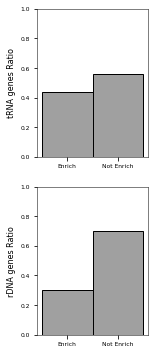

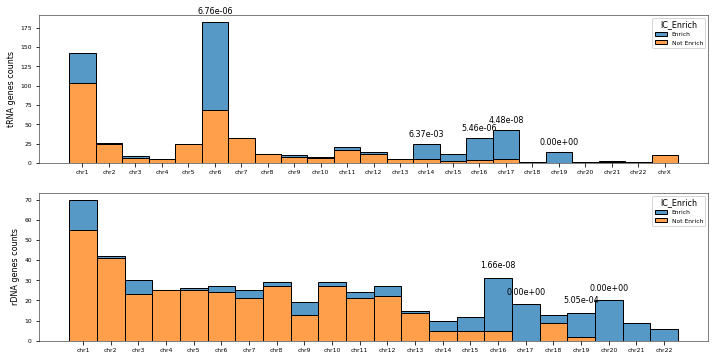

In [58]:
# tRNA, rDNA Inter contact gene numbers
plt.figure(figsize=(2,6))
ax1 = plt.subplot(2,1,1)
sns.histplot(tRNA_df,
             x = "IC_Enrich",
            stat  = "probability",
            discrete = True, color = "grey")
plt.ylabel("tRNA genes Ratio")
plt.xlabel("")
plt.ylim([0, 1])

ax2 = plt.subplot(2,1,2)
sns.histplot(rDNA_df,
             x = "IC_Enrich",
            stat  = "probability",
            discrete = True, color = "grey")
plt.ylabel("rDNA genes Ratio")
plt.ylim([0, 1])
plt.xlabel("")
plt.savefig("tRNA_rDNA_IC_enrich_stat.pdf")

## In each chromosomes
plt.figure(figsize=(12,6))
ax1 = plt.subplot(2,1,1)
sns.histplot(tRNA_df,
            x = "chrom",
            hue = "IC_Enrich", multiple = "stack",
            stat  = "count", discrete = True, color = "grey")
plt.ylabel("tRNA genes counts")
plt.xlabel("")
for n, rowvalue in tRNA_pvalue.iterrows():
    if rowvalue["chrom"] == "chrX":
        chromI = 23 - 1
    else:
        chromI = int( rowvalue["chrom"].replace("chr","") ) - 1
        
    Y = rowvalue["gene_counts"] + 10
    p_result = rowvalue["p_adjusted"]
    if p_result < 0.05:
        plt.text(chromI, Y, "%.2e"%p_result, ha="center")

ax2 = plt.subplot(2,1,2)
sns.histplot(rDNA_df,
            x = "chrom",
            hue = "IC_Enrich", multiple = "stack",
            stat  = "count", discrete = True, color = "grey")
plt.ylabel("rDNA genes counts")
for n, rowvalue in rDNA_pvalue.iterrows():
    chromI = int( rowvalue["chrom"].replace("chr","") ) - 1
    Y = rowvalue["gene_counts"] + 5
    p_result = rowvalue["p_adjusted"]
    if p_result < 0.05:
        plt.text(chromI, Y, "%.2e"%p_result, ha="center")

plt.xlabel("")
plt.savefig("tRNA_rDNA_IC_enrich_all_chroms.pdf")


In [61]:
Exportfile="chromosome_interchromosome_tRNA_enrichment.csv"
tRNA_pvalue.to_csv(Exportfile, header=True, index=False, sep="\t")

In [59]:
chrombin_df

,chrom,start,end,binType,binID,bintag,HubType,Enrichment_bins,HubTypes
bintag,,,,,,,,,
chr1_0,chr1,0,1000000,telo,1,chr1_0,3,1,Other
chr1_1,chr1,1000000,2000000,normal,2,chr1_1,3,1,Other
chr1_2,chr1,2000000,3000000,normal,3,chr1_2,3,1,Other
chr1_3,chr1,3000000,4000000,normal,4,chr1_3,3,1,Other
chr1_4,chr1,4000000,5000000,normal,5,chr1_4,3,1,Other
...,...,...,...,...,...,...,...,...,...
chrX_152,chrX,152000000,153000000,normal,3040,chrX_152,3,0,Other
chrX_153,chrX,153000000,154000000,normal,3041,chrX_153,3,0,Other
chrX_154,chrX,154000000,155000000,normal,3042,chrX_154,3,0,Other


In [ ]:
from statsmodels.stats.multitest import multipletests
raw_pvals = BP_freq.p_value.values
alpha = 0.01 # FDR 0.01
rejected, p_adjusted, _, alpha_corrected = multipletests(raw_pvals, alpha=alpha, 
                               method='bonferroni', is_sorted=False, returnsorted=False)
print( np.sum(rejected), alpha_corrected   )

import seaborn as sns
sns.kdeplot(raw_pvals, color="red", shade=True, label='raw')
ax = sns.kdeplot(p_adjusted, color="green", shade=True, label='adujusted')
ax.set(xlim=(0, 1))
plt.title('distribution of p-values')
plt.legend()

In [ ]:
BP_freq.sort_values(by="Freq", ascending=False).head(1000)

In [ ]:
# Enrichment Selection
'''
p_adjusted < 0.01, EnrichS >= 2
'''
P = (BP_freq.EnrichS >=2) & (BP_freq.p_adjusted < 0.01 )
## chromosome selects
BP_freq_filter = BP_freq.loc[P, :]
# Get bintag informations
BP_freq_filter.loc[:, "bin1_chrom"] = BP_freq_filter.bin1tag.apply( lambda x: chrombin_df.loc[x,"chrom"] )
BP_freq_filter.loc[:, "bin1_start"] = BP_freq_filter.bin1tag.apply( lambda x: chrombin_df.loc[x,"start"] )
BP_freq_filter.loc[:, "bin1_end"] = BP_freq_filter.bin1tag.apply( lambda x: chrombin_df.loc[x,"end"] )
BP_freq_filter.loc[:, "bin2_chrom"] = BP_freq_filter.bin2tag.apply( lambda x: chrombin_df.loc[x,"chrom"] )
BP_freq_filter.loc[:, "bin2_start"] = BP_freq_filter.bin2tag.apply( lambda x: chrombin_df.loc[x,"start"] )
BP_freq_filter.loc[:, "bin2_end"] = BP_freq_filter.bin2tag.apply( lambda x: chrombin_df.loc[x,"end"] )

# Set color
def ColorValue(x, maxvalue):
    '''
    1. Log scale scores
    2. max scores indicated as black, min scorres indicated as white
    3. 
    '''
    cV = (maxvalue - x)/maxvalue
    if cV <= 0:
        cV = 0
    cV = int(cV * 255 )
    return("%d,%d,%d"%(cV,cV,cV) )

# 颜色转换 白色（255,255,255） 黑色（0,0,0）
maxS = np.log2(BP_freq_filter.EnrichS.max() )
BP_freq_filter.loc[:, "Color"] =  BP_freq_filter.EnrichS.apply( lambda x:  ColorValue(np.log2(x), maxS) )

In [ ]:
# Export
export_cols = ["bin1_chrom", "bin1_start", "bin1_end", "bin2_chrom", "bin2_start", "bin2_end", "Color"]
#Export_file = "/data1/ZJY/Pore-C/Analysis/Jupyter/Figures/Inter_Chromosome/Enrichment_contact.csv"
#BP_freq_filter.loc[:, export_cols].to_csv(Export_file, sep="\t", header=False, index=False)

In [ ]:
# Enrichment score heatmap
n = chrombin_df.shape[0]
EnrichScoreArray = np.zeros((n, n))
bin1index = BP_freq.bin1tag.apply(lambda x: BintagIndex[x] )
bin2index = BP_freq.bin2tag.apply(lambda x: BintagIndex[x] )
EnrichScoreArray[bin1index, bin2index] =  np.log2( BP_freq.EnrichS.values )
EnrichScoreArray[bin2index, bin1index] =  np.log2( BP_freq.EnrichS.values )

In [ ]:
# pltline
plt.figure(figsize=(7,2))
#ax1 = plt.subplot(5,1,1)
plt.plot(chrombin_df.index.values, len(chrombin_df)*[1], "-", 
         color="b", label="chrom")
# telomere
P = chrombin_df.binType == "telo"
Y = 1.5
plt.plot(chrombin_df.loc[P,:].index.values, 
         len(chrombin_df.loc[P,:])*[Y], marker="s", 
         color="g", markersize=6, linewidth=0, label="telomere")
# cent
P = chrombin_df.binType == "cent"
Y = 0.5
plt.plot(chrombin_df.loc[P,:].index.values, 
         len(chrombin_df.loc[P,:])*[1], marker="s", 
         color="pink", markersize=6, linewidth=0, label="centormere")

for chrom, gdf in chrombin_df.groupby("chrom"):
    # chromlabel, and position
    pos = int( gdf.index.values.sum()/ len(gdf)  )
    plt.text(pos, 1.5, chrom, ha="left", va="top", fontsize=6, rotation="vertical")
plt.ylim([0, 2])
plt.legend()
plt.savefig("Inter_chromosomes_contact.enrichment_scores_Annotation.pdf")

In [ ]:
chrombin_df = chrombin_df.set_index("binID")
chrombin_df

In [ ]:
# pltline chromosome annotation
plt.figure(figsize=(7,6))
ax1 = plt.subplot(6,1,1)
plt.plot(chrombin_df.index.values, len(chrombin_df)*[1], "-", 
         color="b", label="chrom")
# telomere
P = chrombin_df.binType == "telo"
plt.plot(chrombin_df.loc[P,:].index.values, 
         len(chrombin_df.loc[P,:])*[1], marker="o", 
         color="k", markersize=1, linewidth=0, label="telomere")
# cent
P = chrombin_df.binType == "cent"
plt.plot(chrombin_df.loc[P,:].index.values, 
         len(chrombin_df.loc[P,:])*[1], marker="s", 
         color="r", markersize=1, linewidth=0, label="centormere")

chrombin_df = chrombin_df.reset_index(drop=True)# reset index 

for chrom, gdf in chrombin_df.groupby("chrom"):
    # chromlabel, and position
    pos = int( gdf.index.values.sum()/ len(gdf)  )
    plt.text(pos, 1.5, chrom, ha="center", va="top", fontsize=6)
plt.ylim([0, 2])
plt.legend(fontsize=6)

## heatmap
ax2 = plt.subplot(6,1,(2,6), sharex=ax1)
### mask
import itertools
mask = np.zeros_like(EnrichScoreArray)
for chrom, gdf in chrombin_df.groupby("chrom"):
    indexlist = gdf.index.to_list()
    for indx, indy in itertools.permutations(indexlist, 2):
        mask[indx, indy] = True
        mask[indx, indx] = True

sns.heatmap(EnrichScoreArray, 
            cmap='coolwarm', 
            mask = mask,
            vmin=0, vmax=2, 
            annot=False,
            square = True,
           xticklabels = False,
           yticklabels = False)
plt.savefig("Inter_chromosomes_contact.enrichment_scores_v1.png", dpi=600)

In [ ]:
chrombin_df

In [ ]:
## 合并连续bins
def MergeBins(df):
    MergeBins = {"chrom":[],
                "start":[],
                "end":[],
                "bintags":[]}
    for n, rowvalue in df.iterrows():
        chrom, start, end, bintag = rowvalue["chrom"], rowvalue["start"], rowvalue["end"], rowvalue["bintag"]
        if len(MergeBins["end"]) == 0 or MergeBins["end"][-1] != start or MergeBins["chrom"][-1] != chrom: # the first bin of chromosome
            MergeBins["chrom"].append(chrom)
            MergeBins["start"].append(start)
            MergeBins["end"].append(end)
            MergeBins["bintags"].append(bintag)
        else:
            MergeBins["end"][-1] = end
            MergeBins["bintags"][-1] = MergeBins["bintags"][-1] + "," + bintag
    MergeBins = pd.DataFrame(MergeBins)
    return(MergeBins)


# Significant Inter-contact  regions
fig = plt.figure(figsize=(6, 8)) 
ax = fig.add_subplot(111) 

# Chrom rectangle
for n, rowvalue in chromlen_df.iterrows():
    chrom, chrlen = rowvalue["chrom"], rowvalue["len"]
    if chrom in ["chr%d"%i for i in range(1, 22+1) ]:
        chrI = int( chrom.replace("chr", "") )
    elif chrom == "chrX":
        chrI = 23
    else:
        continue
    chrS, chrE = 0, chrlen 
    chrom_rect = mpl.patches.Rectangle( (0, chrI-0.25), 
                                         chrE, 0.5, 
                                         color ='whitesmoke',
                                         label = "other" ) 
    ax.add_patch( chrom_rect )
    
    
# Inter-contact regions
## 合并连续的区域
IC_df = chrombin_df.loc[chrombin_df.bintag.isin(filter_bintags), :] 
IC_df = IC_df.sort_values(by=["chrom","start"], ignore_index=True)
IC_df = MergeBins(IC_df)
for n, rowvalue in IC_df.iterrows():
    chrS, chrE = rowvalue["start"], rowvalue["end"]
    if rowvalue["chrom"] == "chrX":
        chrI = 23
    else:
        chrI =  int( rowvalue["chrom"].replace("chr", "") )
    hub_rect = mpl.patches.Rectangle( (chrS, chrI-0.25), 
                                         chrE-chrS, 0.5, 
                                         color = "gold", 
                                         label = "IC_sig") 
    ax.add_patch( hub_rect )
    

plt.xlim([-5*10**6, 255000000]) 
plt.ylim([0,24])
ax.set_yticks([i for i in range(1, 23+1) ] )
chromlist = ["chr%d"%i for i in range(1, 22+1) ]
chromlist.append("chrX")
ax.set_yticklabels(chromlist)
#plt.legend()
plt.savefig("Chromosomes_IC_region_annotation.pdf")

In [ ]:
chrom in ["chr%d"%i for i in range(1, 22+1) ]

In [ ]:
## 合并连续bins
def MergeBins(df):
    MergeBins = {"chrom":[],
                "start":[],
                "end":[],
                "bintags":[]}
    for n, rowvalue in df.iterrows():
        chrom, start, end, bintag = rowvalue["chrom"], rowvalue["start"], rowvalue["end"], rowvalue["bintag"]
        if len(MergeBins["end"]) == 0 or MergeBins["end"][-1] != start or MergeBins["chrom"][-1] != chrom: # the first bin of chromosome
            MergeBins["chrom"].append(chrom)
            MergeBins["start"].append(start)
            MergeBins["end"].append(end)
            MergeBins["bintags"].append(bintag)
        else:
            MergeBins["end"][-1] = end
            MergeBins["bintags"][-1] = MergeBins["bintags"][-1] + "," + bintag
    MergeBins = pd.DataFrame(MergeBins)
    return(MergeBins)


# Significant Inter-contact  regions, tRNA, rDNA plot 
fig = plt.figure(figsize=(6, 8)) 
ax = fig.add_subplot(111) 

# Chrom rectangle
for n, rowvalue in chromlen_df.iterrows():
    chrom, chrlen = rowvalue["chrom"], rowvalue["len"]
    if chrom in ["chr%d"%i for i in range(1, 22+1) ]:
        chrI = int( chrom.replace("chr", "") )
    elif chrom == "chrX":
        chrI = 23
    else:
        continue
    chrS, chrE = 0, chrlen 
    chrom_rect = mpl.patches.Rectangle( (0, chrI-0.25), 
                                         chrE, 0.5, 
                                         color ='whitesmoke',
                                         label = "other" ) 
    ax.add_patch( chrom_rect )
    
    
# Inter-contact regions
## 合并连续的区域
IC_df = chrombin_df.loc[chrombin_df.bintag.isin(filter_bintags), :] 
IC_df = IC_df.sort_values(by=["chrom","start"], ignore_index=True)
IC_df = MergeBins(IC_df)
for n, rowvalue in IC_df.iterrows():
    chrS, chrE = rowvalue["start"], rowvalue["end"]
    if  rowvalue["chrom"] == "chrX":
        chrI = 23
    else:
        chrI =  int( rowvalue["chrom"].replace("chr", "") )
    hub_rect = mpl.patches.Rectangle( (chrS, chrI-0.25), 
                                         chrE-chrS, 0.5, 
                                         color = "gold", alpha=0.5,
                                         label = "IC_sig") 
    ax.add_patch( hub_rect )
    

# Telomere, Centromere Annatation
Tel_Cent_df = chrombin_df.loc[chrombin_df.binType.isin(["cent","telo"]), :]
Tel_Cent_df = Tel_Cent_df.sort_values(by=["chrom","start"], ignore_index=True)
Tel_Cent_df = MergeBins(Tel_Cent_df)

for n, rowvalue in Tel_Cent_df.iterrows():
    chrS, chrE = rowvalue["start"], rowvalue["end"]
    if  rowvalue["chrom"] == "chrX":
        chrI = 23
    else:
        chrI =  int( rowvalue["chrom"].replace("chr", "") )
    bin_rect = mpl.patches.Rectangle( (chrS, chrI-0.25), 
                                         chrE-chrS, 0.5, 
                                         color = "grey", alpha=0.5,
                                         label = "Telo_Cent") 
    ax.add_patch( bin_rect )
    

# Cluster Hub rectagle
HubColor = {0: "b",
            1: "r"}
for n, rowvalue in chrombin_df.loc[chrombin_df.HubType.isin([0,1]), :].iterrows():
    HubType = rowvalue["HubType"]
    chrS, chrE = rowvalue["start"], rowvalue["end"]
    if  rowvalue["chrom"] == "chrX":
        chrI = 23
    else:
        chrI =  int( rowvalue["chrom"].replace("chr", "") )
    hub_rect = mpl.patches.Rectangle( (chrS, chrI-0.25), 
                                         chrE-chrS, 0.5, 
                                         color =HubColor[HubType], 
                                         label = "Hub_%d"%HubType) 
    ax.add_patch( hub_rect )
    
    
plt.xlim([-5*10**6, 255000000]) 
plt.ylim([0,24])
ax.set_yticks([i for i in range(1, 23+1) ] )
chromlist = ["chr%d"%i for i in range(1, 22+1) ]
chromlist.append("chrX")
ax.set_yticklabels(chromlist)
#plt.legend()


#plt.legend()
plt.savefig("Chromosomes_Hub_Cluster_Contactbins_v1.pdf")

In [ ]:
Tel_Cent_df

In [ ]:
chrombin_df.loc[chrombin_df.binType.isin(["cent","telo"]), :].tail(20)

In [ ]:
MergeBins.head(20)

In [ ]:
# Hub Cluster, tRNA, rDNA plot 
fig = plt.figure(figsize=(6, 8)) 
ax = fig.add_subplot(111) 

# Chrom rectangle
for n, rowvalue in chromlen_df.iterrows():
    chrom, chrlen = rowvalue["chrom"], rowvalue["len"]
    if chrom in ["chr%d"%i for i in range(1, 22+1) ]:
        chrI = int( chrom.replace("chr", "") )
    else:
        continue
    chrS, chrE = 0, chrlen 
    chrom_rect = mpl.patches.Rectangle( (0, chrI-0.25), 
                                         chrE, 0.5, 
                                         color ='whitesmoke',
                                         label = "other" ) 
    ax.add_patch( chrom_rect )
    

# Telomere, Centromere Annatation
#for n, rowvalue in chrombin_df.loc[chrombin_df.binType.isin(["cent","telo"]), :].iterrows():
#    Type = rowvalue["binType"]
#    chrS, chrE = rowvalue["start"], rowvalue["end"]
#    chrI =  int( rowvalue["chrom"].replace("chr", "") )
#    bin_rect = mpl.patches.Rectangle( (chrS, chrI-0.25), 
#                                         chrE-chrS, 0.5, 
#                                         color = "grey",
#                                         label = Type) 
#    ax.add_patch( bin_rect )
    
    
# Cluster Hub rectagle
HubColor = {0: "b",
            1: "r"}
for n, rowvalue in chrombin_df.loc[chrombin_df.HubType.isin([0,1]), :].iterrows():
    HubType = rowvalue["HubType"]
    chrS, chrE = rowvalue["start"], rowvalue["end"]
    chrI =  int( rowvalue["chrom"].replace("chr", "") )
    hub_rect = mpl.patches.Rectangle( (chrS, chrI-0.25), 
                                         chrE-chrS, 0.5, 
                                         color =HubColor[HubType], 
                                         label = "Hub_%d"%HubType) 
    ax.add_patch( hub_rect )
    
# tRNA rectagle
#for n, rowvalue in tRNA_df.iterrows():
#    chrS, chrE = rowvalue["start"], rowvalue["end"]
#    chrI =  int( rowvalue["chrom"].replace("chr", "") ) + 0.1
#    gene_rect = mpl.patches.Rectangle( (chrS, chrI), 
#                                        0.01*10**6, 0.15, 
#                                         color = "k",
#                                         label = "tRNA") 
#    ax.add_patch( gene_rect )
    
# tRNA rectagle
#for n, rowvalue in rDNA_df.iterrows():
#    chrS, chrE = rowvalue["start"], rowvalue["end"]
#    chrI =  int( rowvalue["chrom"].replace("chr", "") ) - 0.25
#    gene_rect = mpl.patches.Rectangle( (chrS, chrI), 
#                                        0.01*10**6, 0.15, 
#                                         color = "g",
#                                         label = "tRNA") 
#    ax.add_patch( gene_rect )
    
    
plt.xlim([-5*10**6, 255000000]) 
plt.ylim([0,23])
ax.set_yticks([i for i in range(1, 22+1) ] )
ax.set_yticklabels(["chr%d"%i for i in range(1, 22+1) ])
#plt.legend()
plt.savefig("Chromosomes_Hub_Cluster_Contactbins_v1.pdf")

In [ ]:
# Hub Cluster, tRNA, rDNA plot 

# Significant Inter-contact  regions, tRNA, rDNA plot 
fig = plt.figure(figsize=(6, 8)) 
ax = fig.add_subplot(111) 

# Chrom rectangle
for n, rowvalue in chromlen_df.iterrows():
    chrom, chrlen = rowvalue["chrom"], rowvalue["len"]
    if chrom in ["chr%d"%i for i in range(1, 22+1) ]:
        chrI = int( chrom.replace("chr", "") )
    elif chrom == "chrX":
        chrI = 23
    else:
        continue
    chrS, chrE = 0, chrlen 
    chrom_rect = mpl.patches.Rectangle( (0, chrI-0.25), 
                                         chrE, 0.5, 
                                         color ='whitesmoke',
                                         label = "other" ) 
    ax.add_patch( chrom_rect )
    
    
# Inter-contact regions
## 合并连续的区域
IC_df = chrombin_df.loc[chrombin_df.bintag.isin(filter_bintags), :] 
IC_df = IC_df.sort_values(by=["chrom","start"], ignore_index=True)
IC_df = MergeBins(IC_df)
for n, rowvalue in IC_df.iterrows():
    chrS, chrE = rowvalue["start"], rowvalue["end"]
    if  rowvalue["chrom"] == "chrX":
        chrI = 23
    else:
        chrI =  int( rowvalue["chrom"].replace("chr", "") )
    hub_rect = mpl.patches.Rectangle( (chrS, chrI-0.25), 
                                         chrE-chrS, 0.5, 
                                         color = "gold", alpha=0.5,
                                         label = "IC_sig") 
    ax.add_patch( hub_rect )
    

# Telomere, Centromere Annatation
Tel_Cent_df = chrombin_df.loc[chrombin_df.binType.isin(["cent","telo"]), :]
Tel_Cent_df = Tel_Cent_df.sort_values(by=["chrom","start"], ignore_index=True)
Tel_Cent_df = MergeBins(Tel_Cent_df)

for n, rowvalue in Tel_Cent_df.iterrows():
    chrS, chrE = rowvalue["start"], rowvalue["end"]
    if  rowvalue["chrom"] == "chrX":
        chrI = 23
    else:
        chrI =  int( rowvalue["chrom"].replace("chr", "") )
    bin_rect = mpl.patches.Rectangle( (chrS, chrI-0.25), 
                                         chrE-chrS, 0.5, 
                                         color = "grey", alpha=0.5,
                                         label = "Telo_Cent") 
    ax.add_patch( bin_rect )
    

# Cluster Hub rectagle
HubColor = {0: "b",
            1: "r"}
for n, rowvalue in chrombin_df.loc[chrombin_df.HubType.isin([0,1]), :].iterrows():
    HubType = rowvalue["HubType"]
    chrS, chrE = rowvalue["start"], rowvalue["end"]
    if  rowvalue["chrom"] == "chrX":
        chrI = 23
    else:
        chrI =  int( rowvalue["chrom"].replace("chr", "") )
    hub_rect = mpl.patches.Rectangle( (chrS, chrI-0.25), 
                                         chrE-chrS, 0.5, 
                                         color =HubColor[HubType], 
                                         label = "Hub_%d"%HubType) 
    ax.add_patch( hub_rect )
    
    
plt.xlim([-5*10**6, 255000000]) 
plt.ylim([0,24])
ax.set_yticks([i for i in range(1, 23+1) ] )
chromlist = ["chr%d"%i for i in range(1, 22+1) ]
chromlist.append("chrX")
ax.set_yticklabels(chromlist)
    
# tRNA rectagle
for n, rowvalue in tRNA_df.iterrows():
    chrS, chrE = rowvalue["start"], rowvalue["end"]
    
    if  rowvalue["chrom"] == "chrX":
        chrI = 23 - 0.25
    else:
        chrI =  int( rowvalue["chrom"].replace("chr", "") ) - 0.25
    gene_rect = mpl.patches.Rectangle( (chrS, chrI), 
                                        0.01*10**6, 0.15, 
                                         color = "k",
                                         label = "tRNA") 
    ax.add_patch( gene_rect )
    
    
plt.xlim([-5*10**6, 255000000]) 
plt.ylim([0,24])
ax.set_yticks([i for i in range(1, 23+1) ] )
chromlist = ["chr%d"%i for i in range(1, 22+1) ]
chromlist.append("chrX")
ax.set_yticklabels(chromlist)
#plt.legend()
plt.savefig("Chromosomes_Cluster_bins_distribution(tRNA).pdf")